# Кросс-валидация - бинарная классификация

In [1]:
# расширяем поле, убираем предупреждения
from IPython.core.display import display, HTML
display(HTML('<style>.container {width:95% !important;}</style>'))

import warnings
warnings.filterwarnings('ignore')

C:\Users\pc\AppData\Local\Temp\ipykernel_5716\1328233346.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# Стандартные библиотеки для анализа
import pandas as pd
pd.options.display.float_format = '{:20,.2f}'.format

from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import matplotlib.pylab as pl

In [3]:
import sys
sys.path.append('../')

# Наша разработанная библиотека
from autobinary import AutoTrees, base_pipe

In [4]:
import sklearn as sk
import xgboost as xgb
import matplotlib as mplot
import autobinary as ab

print('sklearn: ', sk.__version__)
print('xgboost: ', xgb.__version__)
print('matplotlib: ', mplot.__version__)
print('autobinary: ', ab.__version__)

sklearn:  1.2.2
xgboost:  1.7.4
matplotlib:  3.7.1
autobinary:  1.0.11


## 1.1 Загрузка выборки

In [5]:
sample = pd.read_csv('../data/train_titanic.csv')

print('Размерность данных:', sample.shape)
sample.head(2)

Размерность данных: (891, 12)


PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   

                                                Name     Sex  \
0                            Braund, Mr. Owen Harris    male   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female   

                   Age  SibSp  Parch     Ticket                 Fare Cabin  \
0                22.00      1      0  A/5 21171                 7.25   NaN   
1                38.00      1      0   PC 17599                71.28   C85   

  Embarked  
0        S  
1        C

In [6]:
num_columns = [
    'Age', 'Fare'
]

cat_columns = [
    'Pclass', 'Sex', 'Embarked', 'SibSp', 'Parch'
]

target = ['Survived']

In [7]:
X_train, X_val, y_train, y_val = train_test_split(
    sample[num_columns+cat_columns],
    sample[target],
    test_size=0.3,
    stratify=sample[target],
    random_state=42
)

In [8]:
y_train[target].value_counts()

Survived
0           384
1           239
dtype: int64

In [9]:
y_val[target].value_counts()

Survived
0           165
1           103
dtype: int64

## 1.2 Определяем конвейер обработки, стратегию CV

In [10]:
prep_pipe = base_pipe(
    num_columns=num_columns, 
    cat_columns=cat_columns)

Определены количественные и категориальные переменные!


In [11]:
# задаем стратегию проверки
strat = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42)

## 2. DecisionTreeClassifier

In [12]:
params = {
    'criterion':'gini',
    'max_depth':5,
    'random_state':42}

fit_params = {}

dt = DecisionTreeClassifier(**params)

In [13]:
dt_model = AutoTrees(
    main_estimator=dt, 
    main_fit_params=fit_params,
    main_prep_pipe = prep_pipe,
    main_features=num_columns+cat_columns,
    
    X_train=X_train,
    y_train=y_train,
    
    main_metric='gini',
    model_type = 'decisiontree')

In [14]:
dt_model.model_fit_cv(strat=strat)

0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
gini на обучающей выборке: 86.780
gini на проверочной выборке: 51.407

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


2it [00:00, 18.06it/s]

gini на обучающей выборке: 85.185
gini на проверочной выборке: 56.683

********************** 2 фолд обучен! ******************************




4it [00:00, 18.55it/s]

==================== Обучение 3 фолда! ====================
gini на обучающей выборке: 83.507
gini на проверочной выборке: 57.522

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
gini на обучающей выборке: 80.817
gini на проверочной выборке: 77.342

********************** 4 фолд обучен! ******************************




5it [00:00, 18.57it/s]

==================== Обучение 5 фолда! ====================
gini на обучающей выборке: 81.900
gini на проверочной выборке: 69.353

********************** 5 фолд обучен! ******************************




In [15]:
dt_model.get_mean_cv_scores()

62.46126983319033

In [16]:
dt_model.get_extra_scores()

names               fold_1               fold_2               fold_3  \
0   roc_train                 0.93                 0.93                 0.92   
1   roc_valid                 0.76                 0.78                 0.79   
2  gini_train                86.78                85.19                83.51   
3  gini_valid                51.41                56.68                57.52   

                fold_4               fold_5  
0                 0.90                 0.91  
1                 0.89                 0.85  
2                80.82                81.90  
3                77.34                69.35

In [17]:
fi = dt_model.get_fi()
fi

index         importance 0         importance 1         importance 2  \
0       Sex                 0.53                 0.51                 0.55   
1      Fare                 0.16                 0.15                 0.13   
2       Age                 0.12                 0.12                 0.13   
3    Pclass                 0.10                 0.11                 0.12   
4     SibSp                 0.07                 0.05                 0.02   
5     Parch                 0.02                 0.04                 0.03   
6  Embarked                 0.01                 0.02                 0.01   

          importance 3         importance 4      mean_importance  
0                 0.52                 0.54                 0.53  
1                 0.14                 0.17                 0.15  
2                 0.12                 0.11                 0.12  
3                 0.13                 0.10                 0.11  
4                 0.05                 0.04                 0.04  
5                 0.04                 0.05                 0.04  
6                 0.01                 0.00                 0.01

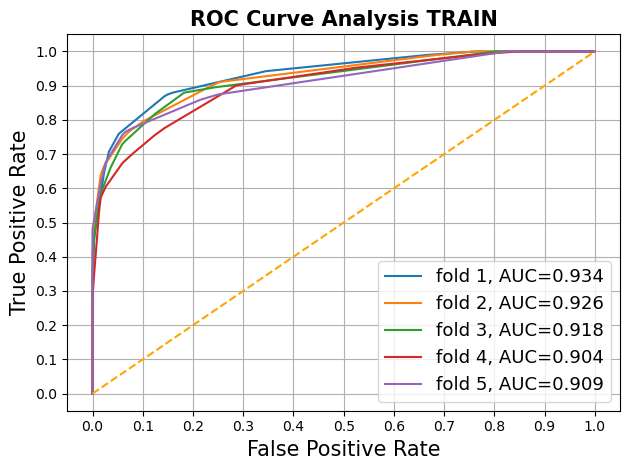

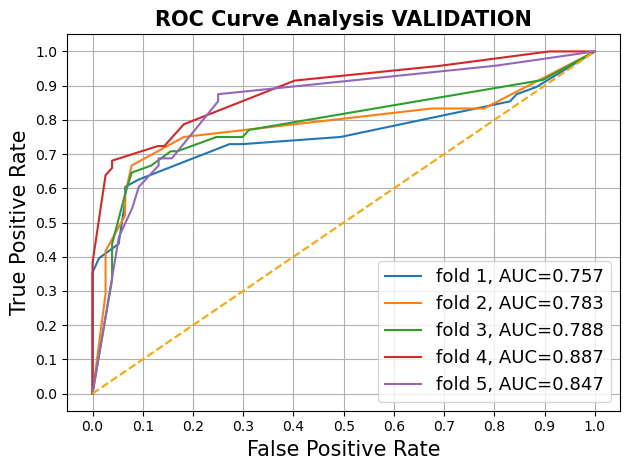

In [18]:
dt_model.get_rocauc_plots()

## 3. RandomForestClassifier

In [19]:
params = {
    'criterion':'gini',
    'max_depth':5,
    'random_state':42,
    'n_estimators':50}

fit_params = {}

rf = RandomForestClassifier(**params)

In [20]:
rf_model = AutoTrees(
    main_estimator=rf, 
    main_fit_params=fit_params,
    main_prep_pipe = prep_pipe,
    main_features=num_columns+cat_columns,
    
    X_train=X_train,
    y_train=y_train,
    
    main_metric='gini',
    model_type = 'randomforest')

In [21]:
rf_model.model_fit_cv(strat=strat)

1it [00:00,  9.11it/s]

==================== Обучение 1 фолда! ====================
gini на обучающей выборке: 86.242
gini на проверочной выборке: 61.851

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


3it [00:00,  9.24it/s]

gini на обучающей выборке: 84.622
gini на проверочной выборке: 72.971

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
gini на обучающей выборке: 85.622
gini на проверочной выборке: 68.642

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================


5it [00:00,  9.27it/s]

gini на обучающей выборке: 83.671
gini на проверочной выборке: 77.950

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
gini на обучающей выборке: 84.244
gini на проверочной выборке: 79.194

********************** 5 фолд обучен! ******************************




In [22]:
rf_model.get_mean_cv_scores()

72.12139845503506

In [23]:
rf_model.get_extra_scores()

names               fold_1               fold_2               fold_3  \
0   roc_train                 0.93                 0.92                 0.93   
1   roc_valid                 0.81                 0.86                 0.84   
2  gini_train                86.24                84.62                85.62   
3  gini_valid                61.85                72.97                68.64   

                fold_4               fold_5  
0                 0.92                 0.92  
1                 0.89                 0.90  
2                83.67                84.24  
3                77.95                79.19

In [24]:
fi = rf_model.get_fi()
fi

index         importance 0         importance 1         importance 2  \
0       Sex                 0.39                 0.34                 0.36   
1      Fare                 0.21                 0.24                 0.26   
2    Pclass                 0.13                 0.15                 0.11   
3       Age                 0.10                 0.11                 0.10   
4     Parch                 0.06                 0.07                 0.07   
5     SibSp                 0.07                 0.06                 0.06   
6  Embarked                 0.04                 0.04                 0.04   

          importance 3         importance 4      mean_importance  
0                 0.34                 0.39                 0.36  
1                 0.22                 0.22                 0.23  
2                 0.15                 0.10                 0.13  
3                 0.10                 0.13                 0.11  
4                 0.06                 0.07                 0.07  
5                 0.07                 0.06                 0.06  
6                 0.05                 0.04                 0.04

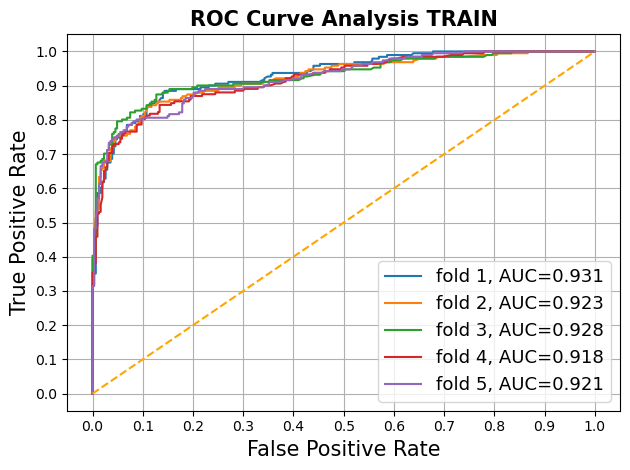

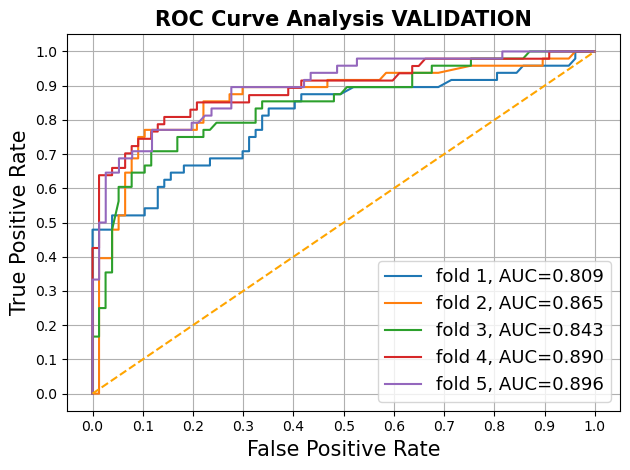

In [25]:
rf_model.get_rocauc_plots()

## 4. XGBClassifier + delta_gini

In [26]:
params = {
    'eta':0.01,
    'n_estimators':800,
    'subsample':0.9,
    'colsample_bytree':0.6,
    'max_depth':6,
    'objective':'binary:logistic',
    'use_label_encoder':False,
    'n_jobs':-1,
    'random_state':42}

fit_params = {
    'early_stopping_rounds':100, 
    'eval_metric':['logloss', 'aucpr', 'auc'],
    'verbose':25}

# создаем экземпляр класса XGBClassifier
xgb = XGBClassifier(**params)

In [27]:
xgb_model = AutoTrees(
    main_estimator=xgb, 
    main_fit_params=fit_params,
    main_prep_pipe = prep_pipe,
    main_features=num_columns+cat_columns,
    
    X_train=X_train,
    y_train=y_train,
    
    main_metric='delta_gini',
    model_type = 'xgboost')

In [28]:
xgb_model.model_fit_cv(strat=strat)

0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
[0]	validation_0-logloss:0.68837	validation_0-aucpr:0.83837	validation_0-auc:0.88663	validation_1-logloss:0.68978	validation_1-aucpr:0.71508	validation_1-auc:0.78409
[25]	validation_0-logloss:0.60432	validation_0-aucpr:0.91959	validation_0-auc:0.93183	validation_1-logloss:0.63478	validation_1-aucpr:0.78105	validation_1-auc:0.80181
[50]	validation_0-logloss:0.53875	validation_0-aucpr:0.92303	validation_0-auc:0.93572	validation_1-logloss:0.58966	validation_1-aucpr:0.80640	validation_1-auc:0.81683
[75]	validation_0-logloss:0.48799	validation_0-aucpr:0.92328	validation_0-auc:0.93697	validation_1-logloss:0.55711	validation_1-aucpr:0.80682	validation_1-auc:0.81764
[100]	validation_0-logloss:0.44802	validation_0-aucpr:0.92906	validation_0-auc:0.94309	validation_1-logloss:0.53694	validation_1-aucpr:0.80746	validation_1-auc:0.81737
[125]	validation_0-logloss:0.41824	validation_0-aucpr:0.93270	validation_0-auc:0.94636	validation_1-loglo

1it [00:00,  5.07it/s]

BEST ITERATION:  82
delta_gini на обучающей выборке: nan
delta_gini на проверочной выборке: 0.373

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
[0]	validation_0-logloss:0.68837	validation_0-aucpr:0.86615	validation_0-auc:0.87965	validation_1-logloss:0.68984	validation_1-aucpr:0.66651	validation_1-auc:0.77286
[25]	validation_0-logloss:0.60726	validation_0-aucpr:0.91587	validation_0-auc:0.92676	validation_1-logloss:0.62945	validation_1-aucpr:0.76303	validation_1-auc:0.84023
[50]	validation_0-logloss:0.54468	validation_0-aucpr:0.91806	validation_0-auc:0.92824	validation_1-logloss:0.58218	validation_1-aucpr:0.78113	validation_1-auc:0.84781
[75]	validation_0-logloss:0.49455	validation_0-aucpr:0.92049	validation_0-auc:0.93095	validation_1-logloss:0.54489	validation_1-aucpr:0.79221	validation_1-auc:0.85376
[100]	validation_0-logloss:0.45617	validation_0-aucpr:0.92544	validation_0-auc:0.93593	validation_1-log

2it [00:00,  6.14it/s]

BEST ITERATION:  6
delta_gini на обучающей выборке: nan
delta_gini на проверочной выборке: 0.209

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
[0]	validation_0-logloss:0.68837	validation_0-aucpr:0.84959	validation_0-auc:0.87742	validation_1-logloss:0.68983	validation_1-aucpr:0.72152	validation_1-auc:0.77665
[25]	validation_0-logloss:0.60626	validation_0-aucpr:0.92048	validation_0-auc:0.93234	validation_1-logloss:0.62798	validation_1-aucpr:0.79379	validation_1-auc:0.84889
[50]	validation_0-logloss:0.54309	validation_0-aucpr:0.92477	validation_0-auc:0.93388	validation_1-logloss:0.58050	validation_1-aucpr:0.81125	validation_1-auc:0.86228
[75]	validation_0-logloss:0.49171	validation_0-aucpr:0.92651	validation_0-auc:0.93561	validation_1-logloss:0.54340	validation_1-aucpr:0.80992	validation_1-auc:0.86215
[100]	validation_0-logloss:0.45204	validation_0-aucpr:0.93101	validation_0-auc:0.93990	validation_1-logl

3it [00:00,  6.11it/s]

delta_gini на обучающей выборке: nan
delta_gini на проверочной выборке: 0.200

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
[0]	validation_0-logloss:0.68877	validation_0-aucpr:0.84134	validation_0-auc:0.88199	validation_1-logloss:0.68886	validation_1-aucpr:0.82729	validation_1-auc:0.86170
[25]	validation_0-logloss:0.60951	validation_0-aucpr:0.90778	validation_0-auc:0.91948	validation_1-logloss:0.61318	validation_1-aucpr:0.89601	validation_1-auc:0.91324
[50]	validation_0-logloss:0.54821	validation_0-aucpr:0.91369	validation_0-auc:0.92657	validation_1-logloss:0.55726	validation_1-aucpr:0.89369	validation_1-auc:0.91130
[75]	validation_0-logloss:0.49970	validation_0-aucpr:0.91620	validation_0-auc:0.92886	validation_1-logloss:0.51136	validation_1-aucpr:0.89403	validation_1-auc:0.90978
[100]	validation_0-logloss:0.46810	validation_0-aucpr:0.92189	validation_0-auc:0.93384	validation_1-logloss:0.48744	validat

4it [00:00,  6.44it/s]

BEST ITERATION:  22
delta_gini на обучающей выборке: nan
delta_gini на проверочной выборке: 0.010

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
[0]	validation_0-logloss:0.68840	validation_0-aucpr:0.85492	validation_0-auc:0.87223	validation_1-logloss:0.68910	validation_1-aucpr:0.80225	validation_1-auc:0.84690
[25]	validation_0-logloss:0.60713	validation_0-aucpr:0.90503	validation_0-auc:0.91292	validation_1-logloss:0.61627	validation_1-aucpr:0.86568	validation_1-auc:0.88130
[50]	validation_0-logloss:0.54537	validation_0-aucpr:0.91417	validation_0-auc:0.92230	validation_1-logloss:0.56117	validation_1-aucpr:0.87012	validation_1-auc:0.88802
[75]	validation_0-logloss:0.49561	validation_0-aucpr:0.91520	validation_0-auc:0.92414	validation_1-logloss:0.51863	validation_1-aucpr:0.87126	validation_1-auc:0.89474
[100]	validation_0-logloss:0.46391	validation_0-aucpr:0.91984	validation_0-auc:0.92755	validation_1-log

5it [00:00,  5.74it/s]

BEST ITERATION:  131
delta_gini на обучающей выборке: nan
delta_gini на проверочной выборке: 0.083

********************** 5 фолд обучен! ******************************




5it [00:00,  5.88it/s]


In [29]:
xgb_model.get_mean_cv_scores()

0.17503374832895463

In [30]:
xgb_model._best_iters

[82, 6, 57, 22, 131]

In [31]:
xgb_model.get_extra_scores()

names               fold_1               fold_2               fold_3  \
0   roc_train                 0.94                 0.92                 0.93   
1   roc_valid                 0.82                 0.85                 0.86   
2  gini_train                87.67                83.47                86.87   
3  gini_valid                63.85                69.02                72.40   

                fold_4               fold_5  
0                 0.92                 0.93  
1                 0.91                 0.90  
2                83.59                86.51  
3                82.76                79.88

In [32]:
fi = xgb_model.get_fi()
fi

index         importance 0         importance 1         importance 2  \
0       Sex                56.14                67.81                60.06   
1    Pclass                 9.28                 9.87                 6.42   
2     Parch                 1.99                 2.92                 2.95   
3      Fare                 2.11                 3.23                 2.82   
4     SibSp                 1.95                 2.08                 1.79   
5  Embarked                 1.86                 1.79                 1.57   
6       Age                 1.78                 1.79                 1.70   

          importance 3         importance 4      mean_importance  
0                62.93                48.77                59.14  
1                10.05                 4.69                 8.06  
2                 2.86                 2.06                 2.55  
3                 2.27                 2.14                 2.51  
4                 2.68                 1.66                 2.03  
5                 2.27                 1.42                 1.78  
6                 1.75                 1.56                 1.72

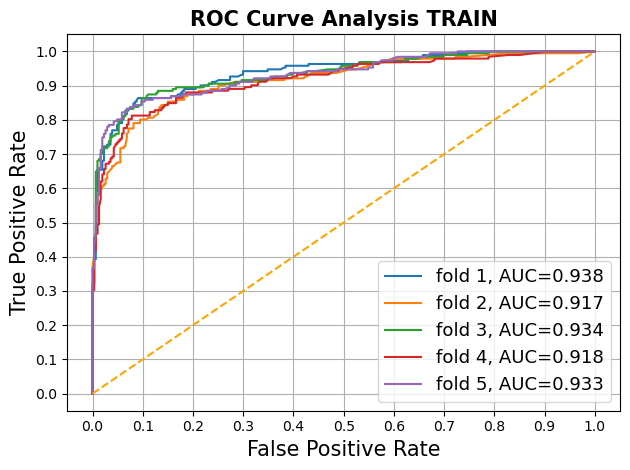

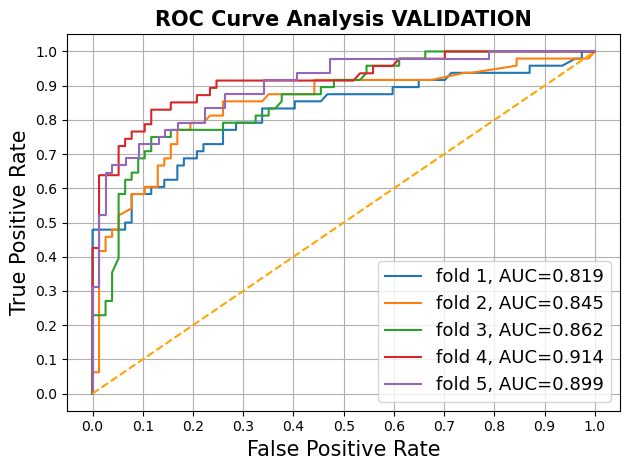

In [33]:
xgb_model.get_rocauc_plots()

In [34]:
xgb_model.get_curve_plots()

## 5. CatBoostClassifier CPU

In [35]:
params = {
    'learning_rate':0.01,
    'iterations':1000,
    'subsample':0.9,
    'colsample_bylevel':0.9,
    'depth':6,
    'loss_function':'Logloss',
    'thread_count':-1,
    'random_state':42,
    'eval_metric':'AUC',
    #'custom_metric':'Logloss',
    'logging_level':'Verbose'}

fit_params = {
    'use_best_model':True,
    'early_stopping_rounds':200, 
    'verbose':50,
    'plot':False}

# создаем экземпляр класса XGBClassifier
catb = CatBoostClassifier(**params)

In [36]:
catb_model = AutoTrees(
    main_estimator=catb, 
    main_fit_params=fit_params,
    main_prep_pipe = prep_pipe,
    main_features=num_columns+cat_columns,
    
    X_train=X_train,
    y_train=y_train,
    
    main_metric='gini',
    model_type = 'catboost')

In [37]:
catb_model.model_fit_cv(strat=strat)

0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
0:	test: 0.8373041	test1: 0.7728626	best: 0.7728626 (0)	total: 134ms	remaining: 2m 13s
50:	test: 0.9018197	test1: 0.8104708	best: 0.8129058 (30)	total: 188ms	remaining: 3.49s
100:	test: 0.9136637	test1: 0.8129058	best: 0.8147998 (59)	total: 249ms	remaining: 2.22s
150:	test: 0.9190443	test1: 0.8138528	best: 0.8147998 (59)	total: 310ms	remaining: 1.75s
200:	test: 0.9264884	test1: 0.8165584	best: 0.8165584 (200)	total: 372ms	remaining: 1.48s
250:	test: 0.9337193	test1: 0.8179113	best: 0.8179113 (249)	total: 436ms	remaining: 1.3s
300:	test: 0.9385797	test1: 0.8165584	best: 0.8195346 (270)	total: 497ms	remaining: 1.15s
350:	test: 0.9417859	test1: 0.8203463	best: 0.8203463 (341)	total: 556ms	remaining: 1.03s
400:	test: 0.9451967	test1: 0.8233225	best: 0.8238636 (390)	total: 613ms	remaining: 915ms


1it [00:00,  1.06it/s]

450:	test: 0.9477548	test1: 0.8222403	best: 0.8238636 (390)	total: 666ms	remaining: 811ms
500:	test: 0.9512168	test1: 0.8211580	best: 0.8238636 (390)	total: 720ms	remaining: 717ms
550:	test: 0.9542865	test1: 0.8225108	best: 0.8238636 (390)	total: 773ms	remaining: 630ms
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8238636364
bestIteration = 390

Shrink model to first 391 iterations.
BEST ITERATION:  390
gini на обучающей выборке: 88.903
gini на проверочной выборке: 64.773

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
0:	test: 0.8284360	test1: 0.8145292	best: 0.8145292 (0)	total: 858us	remaining: 858ms
50:	test: 0.8890888	test1: 0.8583604	best: 0.8658009 (38)	total: 50.6ms	remaining: 941ms
100:	test: 0.9011290	test1: 0.8564665	best: 0.8658009 (38)	total: 103ms	remaining: 915ms
150:	test: 0.9077545	test1: 0.8659361	best: 0.8659361 (150)	total: 163ms	remaining: 915ms
200:	test: 0.9

2it [00:01,  1.51it/s]

350:	test: 0.9312465	test1: 0.8645833	best: 0.8659361 (150)	total: 367ms	remaining: 679ms
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8659361472
bestIteration = 150

Shrink model to first 151 iterations.
BEST ITERATION:  150
gini на обучающей выборке: 81.551
gini на проверочной выборке: 73.187

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
0:	test: 0.8275151	test1: 0.8200758	best: 0.8200758 (0)	total: 906us	remaining: 905ms
50:	test: 0.8916895	test1: 0.8349567	best: 0.8369859 (44)	total: 53.1ms	remaining: 987ms
100:	test: 0.9012995	test1: 0.8363095	best: 0.8415855 (61)	total: 103ms	remaining: 913ms
150:	test: 0.9097583	test1: 0.8379329	best: 0.8415855 (61)	total: 154ms	remaining: 866ms
200:	test: 0.9196241	test1: 0.8410444	best: 0.8415855 (61)	total: 206ms	remaining: 820ms
250:	test: 0.9275884	test1: 0.8437500	best: 0.8440206 (220)	total: 259ms	remaining: 774ms
300:	test: 0.931

3it [00:02,  1.55it/s]

350:	test: 0.9360472	test1: 0.8399621	best: 0.8459145 (285)	total: 369ms	remaining: 683ms
400:	test: 0.9400208	test1: 0.8383387	best: 0.8459145 (285)	total: 425ms	remaining: 635ms
450:	test: 0.9437386	test1: 0.8380682	best: 0.8459145 (285)	total: 481ms	remaining: 585ms
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8459145022
bestIteration = 285

Shrink model to first 286 iterations.
BEST ITERATION:  285
gini на обучающей выборке: 86.125
gini на проверочной выборке: 69.183

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
0:	test: 0.8161815	test1: 0.8648798	best: 0.8648798 (0)	total: 881us	remaining: 881ms
50:	test: 0.8840679	test1: 0.8865709	best: 0.8911301 (18)	total: 54.1ms	remaining: 1.01s
100:	test: 0.8947391	test1: 0.8943078	best: 0.8943078 (97)	total: 104ms	remaining: 927ms
150:	test: 0.9035101	test1: 0.8979000	best: 0.8981763 (149)	total: 159ms	remaining: 895ms
200:	test: 0.9

4it [00:02,  1.62it/s]

350:	test: 0.9260485	test1: 0.9009395	best: 0.9014921 (208)	total: 378ms	remaining: 699ms
400:	test: 0.9296281	test1: 0.8976237	best: 0.9014921 (208)	total: 434ms	remaining: 648ms
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9014921249
bestIteration = 208

Shrink model to first 209 iterations.
BEST ITERATION:  208
gini на обучающей выборке: 82.081
gini на проверочной выборке: 80.298

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
0:	test: 0.8188448	test1: 0.8526590	best: 0.8526590 (0)	total: 897us	remaining: 897ms
50:	test: 0.8859302	test1: 0.8873355	best: 0.8929550 (13)	total: 51.7ms	remaining: 962ms
100:	test: 0.8975573	test1: 0.8914474	best: 0.8929550 (13)	total: 101ms	remaining: 896ms
150:	test: 0.9081645	test1: 0.8926809	best: 0.8933662 (144)	total: 153ms	remaining: 859ms
200:	test: 0.9144710	test1: 0.8951480	best: 0.8967928 (169)	total: 205ms	remaining: 815ms
250:	test: 0.9

5it [00:03,  1.56it/s]

450:	test: 0.9374278	test1: 0.8854167	best: 0.8970669 (275)	total: 471ms	remaining: 574ms
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.897066886
bestIteration = 275

Shrink model to first 276 iterations.
BEST ITERATION:  275
gini на обучающей выборке: 84.339
gini на проверочной выборке: 79.413

********************** 5 фолд обучен! ******************************




In [38]:
catb_model.get_mean_cv_scores()

73.37093186302312

In [39]:
catb_model._best_iters

[390, 150, 285, 208, 275]

In [40]:
catb_model.get_extra_scores()

names               fold_1               fold_2               fold_3  \
0   roc_train                 0.94                 0.91                 0.93   
1   roc_valid                 0.82                 0.87                 0.85   
2  gini_train                88.90                81.55                86.12   
3  gini_valid                64.77                73.19                69.18   

                fold_4               fold_5  
0                 0.91                 0.92  
1                 0.90                 0.90  
2                82.08                84.34  
3                80.30                79.41

In [41]:
fi = catb_model.get_fi()
fi

index         importance_0         importance_1         importance_2  \
0       Sex                38.29                50.61                44.16   
1    Pclass                17.36                22.48                17.97   
2       Age                15.23                 7.31                10.20   
3      Fare                11.32                 8.56                11.11   
4     Parch                 7.44                 4.83                 6.69   
5     SibSp                 5.90                 3.64                 5.72   
6  Embarked                 4.46                 2.58                 4.15   

          importance_3         importance_4      mean_importance  
0                44.70                42.85                44.12  
1                19.38                15.34                18.51  
2                 8.64                11.99                10.67  
3                 9.61                10.72                10.26  
4                 6.48                 8.68                 6.82  
5                 6.55                 6.68                 5.70  
6                 4.65                 3.73                 3.91

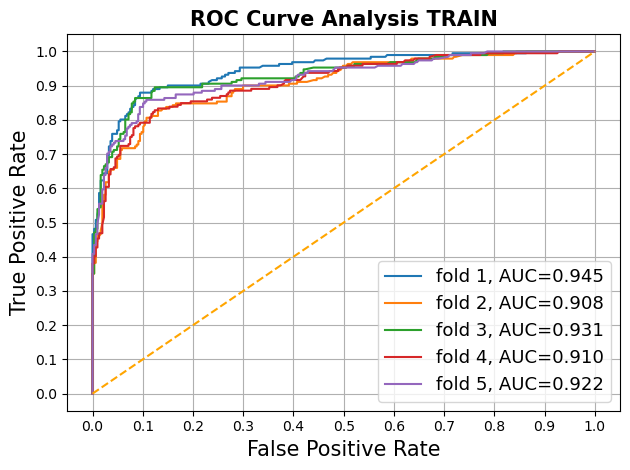

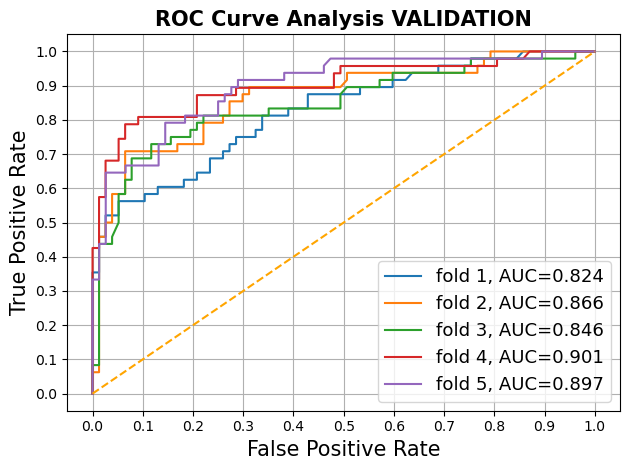

In [42]:
catb_model.get_rocauc_plots()

In [43]:
catb_model.get_curve_plots()

## 6. CatBoostClassifier GPU

In [44]:
params = {
    'learning_rate':0.01,
    'iterations':1000,
    #'subsample':0.9,
    #'colsample_bylevel':0.9,
    'depth':6,
    'loss_function':'Logloss',
    #'thread_count':-1,
    'random_state':42,
    'eval_metric':'AUC',
    'logging_level':'Verbose',
    #'l2_leaf_reg':1,
    'task_type': 'GPU'
    #'bootstrap_type':'Poisson'
}

fit_params = {
    'use_best_model':True,
    'early_stopping_rounds':200, 
    'verbose':50,
    'plot':False}

# создаем экземпляр класса XGBClassifier
catb = CatBoostClassifier(**params)

In [45]:
catb_model = AutoTrees(
    main_estimator=catb, 
    main_fit_params=fit_params,
    main_prep_pipe = prep_pipe,
    main_features=num_columns+cat_columns,
    
    X_train=X_train,
    y_train=y_train,
    
    main_metric='gini',
    model_type = 'catboost_gpu')

In [46]:
catb_model.model_fit_cv(strat=strat)

0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7785444	best: 0.7785444 (0)	total: 29.6ms	remaining: 29.6s
50:	test: 0.8264340	best: 0.8264340 (50)	total: 1.11s	remaining: 20.8s
100:	test: 0.8280573	best: 0.8288690 (85)	total: 2.18s	remaining: 19.4s
150:	test: 0.8285985	best: 0.8300866 (142)	total: 3.37s	remaining: 19s
200:	test: 0.8269751	best: 0.8300866 (142)	total: 4.52s	remaining: 18s
250:	test: 0.8216991	best: 0.8300866 (142)	total: 5.65s	remaining: 16.9s
300:	test: 0.8189935	best: 0.8300866 (142)	total: 6.79s	remaining: 15.8s


1it [00:08,  8.16s/it]

bestTest = 0.8300865889
bestIteration = 142
Shrink model to first 143 iterations.
BEST ITERATION:  142
gini на обучающей выборке: 84.425
gini на проверочной выборке: 66.017

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8405032	best: 0.8405032 (0)	total: 21.9ms	remaining: 21.9s
50:	test: 0.8456439	best: 0.8549784 (10)	total: 1.02s	remaining: 19s
100:	test: 0.8591721	best: 0.8591721 (99)	total: 2.11s	remaining: 18.8s
150:	test: 0.8597132	best: 0.8599838 (143)	total: 3.24s	remaining: 18.2s
200:	test: 0.8653950	best: 0.8653950 (195)	total: 4.36s	remaining: 17.3s
250:	test: 0.8645833	best: 0.8659361 (231)	total: 5.53s	remaining: 16.5s
300:	test: 0.8637716	best: 0.8659361 (231)	total: 6.6s	remaining: 15.3s
350:	test: 0.8670184	best: 0.8670184 (349)	total: 7.7s	remaining: 14.2s
400:	test: 0.8699946	best: 0.8699946 (399)	total: 8.75s	remaining: 13.1s
450:	test: 0.8691829	best: 0.8699946 (399)	total: 9.88s	remaining: 12s
500:	test: 0.8691829	best: 0.8699946 (399)	total: 11s	remaining: 10.9s
550:	test: 0.8691829	best: 0.8702652 (503)	total: 12.1s	remaining: 9.86s
600:	test: 0.8686418	best: 0.8702652 (503)	total: 13.3s	remaining: 8.81s
650:	test: 0.8694535	best: 0.8702652 (503)	total: 14.4s	remaining

2it [00:27, 14.95s/it]

bestTest = 0.8710768521
bestIteration = 660
Shrink model to first 661 iterations.
BEST ITERATION:  660
gini на обучающей выборке: 89.145
gini на проверочной выборке: 74.215

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7954545	best: 0.7954545 (0)	total: 27.2ms	remaining: 27.2s
50:	test: 0.8334686	best: 0.8337392 (19)	total: 1.02s	remaining: 18.9s
100:	test: 0.8318452	best: 0.8354978 (81)	total: 2.07s	remaining: 18.4s
150:	test: 0.8292749	best: 0.8354978 (81)	total: 3.21s	remaining: 18s
200:	test: 0.8336039	best: 0.8359037 (181)	total: 4.38s	remaining: 17.4s
250:	test: 0.8311688	best: 0.8359037 (181)	total: 5.5s	remaining: 16.4s
300:	test: 0.8311688	best: 0.8359037 (181)	total: 6.6s	remaining: 15.3s
350:	test: 0.8300866	best: 0.8359037 (181)	total: 7.78s	remaining: 14.4s


3it [00:36, 12.11s/it]

bestTest = 0.8359036744
bestIteration = 181
Shrink model to first 182 iterations.
BEST ITERATION:  181
gini на обучающей выборке: 82.632
gini на проверочной выборке: 67.181

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8679193	best: 0.8679193 (0)	total: 27.4ms	remaining: 27.4s
50:	test: 0.8948605	best: 0.9014921 (10)	total: 1.2s	remaining: 22.3s
100:	test: 0.8936170	best: 0.9014921 (10)	total: 2.29s	remaining: 20.4s
150:	test: 0.8988671	best: 0.9014921 (10)	total: 3.44s	remaining: 19.4s
200:	test: 0.8991434	best: 0.9014921 (10)	total: 4.63s	remaining: 18.4s


4it [00:41,  9.36s/it]

bestTest = 0.9014921188
bestIteration = 10
Shrink model to first 11 iterations.
BEST ITERATION:  10
gini на обучающей выборке: 74.712
gini на проверочной выборке: 80.298

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7648026	best: 0.7648026 (0)	total: 16.6ms	remaining: 16.5s
50:	test: 0.8859649	best: 0.8937774 (5)	total: 1.1s	remaining: 20.5s
100:	test: 0.8843202	best: 0.8937774 (5)	total: 2.11s	remaining: 18.8s
150:	test: 0.8806195	best: 0.8937774 (5)	total: 3.24s	remaining: 18.2s


5it [00:46,  9.28s/it]

200:	test: 0.8803454	best: 0.8937774 (5)	total: 4.27s	remaining: 17s
bestTest = 0.8937774301
bestIteration = 5
Shrink model to first 6 iterations.
BEST ITERATION:  5
gini на обучающей выборке: 72.901
gini на проверочной выборке: 78.755

********************** 5 фолд обучен! ******************************




In [47]:
catb_model.get_mean_cv_scores()

73.29346546976727

In [48]:
catb_model._best_iters

[142, 660, 181, 10, 5]

In [49]:
catb_model.get_extra_scores()

names               fold_1               fold_2               fold_3  \
0   roc_train                 0.92                 0.95                 0.91   
1   roc_valid                 0.83                 0.87                 0.84   
2  gini_train                84.42                89.15                82.63   
3  gini_valid                66.02                74.22                67.18   

                fold_4               fold_5  
0                 0.87                 0.86  
1                 0.90                 0.89  
2                74.71                72.90  
3                80.30                78.76

In [50]:
fi = catb_model.get_fi()
fi

index         importance_0         importance_1         importance_2  \
0       Sex                47.97                33.26                51.43   
1    Pclass                16.43                16.67                18.10   
2      Fare                13.69                22.62                15.06   
3       Age                12.34                17.71                 6.74   
4     Parch                 3.48                 4.10                 4.26   
5     SibSp                 4.49                 4.17                 1.73   
6  Embarked                 1.59                 1.48                 2.68   

          importance_3         importance_4      mean_importance  
0                63.63                69.79                53.22  
1                21.65                19.69                18.51  
2                 6.08                 3.98                12.29  
3                 2.01                 1.92                 8.15  
4                 3.45                 0.98                 3.25  
5                 1.24                 3.07                 2.94  
6                 1.94                 0.58                 1.65

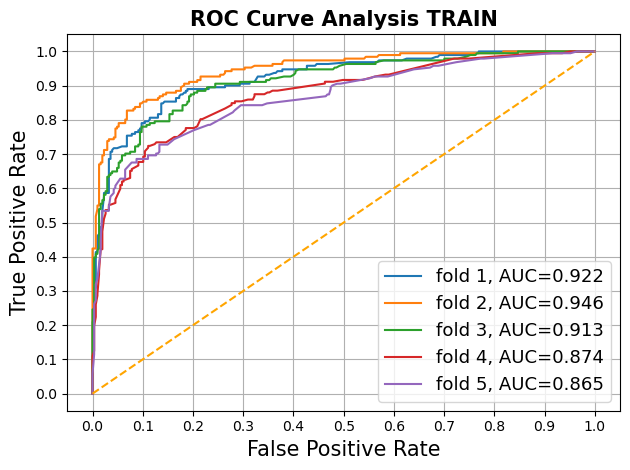

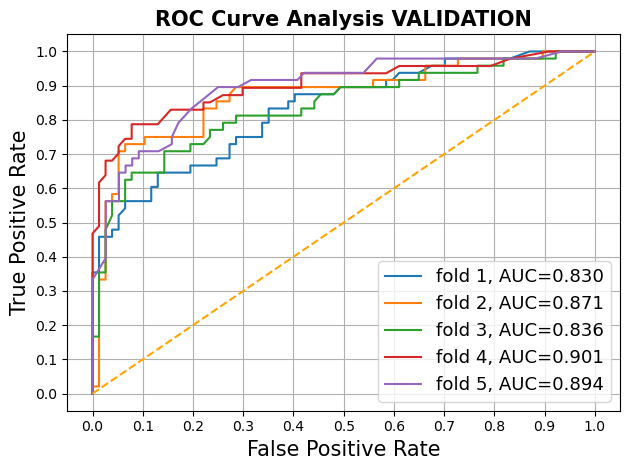

In [51]:
catb_model.get_rocauc_plots()

## 7. LGBMClassifier

In [52]:
params = {
    'learning_rate':0.01,
    'n_estimators':1000,
    'subsample':0.9,
    'colsample_bytree':0.6,
    'max_depth':6,
    'objective':'binary',
    'n_jobs':-1,
    'random_state':42,
#    'eval_metric':'auc'
}

fit_params = {
    'early_stopping_rounds':100, 
    'eval_metric':['logloss', 'auc'],
    'verbose':25}

# создаем экземпляр класса LightGBM
lgb = LGBMClassifier(**params)

In [53]:
lgb_model = AutoTrees(
    main_estimator=lgb, 
    main_fit_params=fit_params,
    main_prep_pipe = prep_pipe,
    main_features=num_columns+cat_columns,
    
    X_train=X_train,
    y_train=y_train,
    
    main_metric='gini',
    model_type = 'lightboost')

In [54]:
lgb_model.model_fit_cv(strat=strat)

2it [00:00,  9.60it/s]

==================== Обучение 1 фолда! ====================
[25]	training's binary_logloss: 0.588642	training's auc: 0.91409	valid_1's binary_logloss: 0.610696	valid_1's auc: 0.802895
[50]	training's binary_logloss: 0.532684	training's auc: 0.920656	valid_1's binary_logloss: 0.575504	valid_1's auc: 0.797754
[75]	training's binary_logloss: 0.49109	training's auc: 0.925098	valid_1's binary_logloss: 0.551861	valid_1's auc: 0.797348
[100]	training's binary_logloss: 0.457261	training's auc: 0.926292	valid_1's binary_logloss: 0.532354	valid_1's auc: 0.796807
BEST ITERATION:  23
gini на обучающей выборке: 82.832
gini на проверочной выборке: 61.012

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
[25]	training's binary_logloss: 0.591783	training's auc: 0.902809	valid_1's binary_logloss: 0.608713	valid_1's auc: 0.834821
[50]	training's binary_logloss: 0.537394	training's auc: 0.911788	valid_1's binary_logloss: 0.

3it [00:00,  8.09it/s]

==================== Обучение 3 фолда! ====================
[25]	training's binary_logloss: 0.590874	training's auc: 0.907089	valid_1's binary_logloss: 0.607255	valid_1's auc: 0.832792
[50]	training's binary_logloss: 0.536839	training's auc: 0.917501	valid_1's binary_logloss: 0.5676	valid_1's auc: 0.837662
[75]	training's binary_logloss: 0.497226	training's auc: 0.920588	valid_1's binary_logloss: 0.541407	valid_1's auc: 0.840097
[100]	training's binary_logloss: 0.464638	training's auc: 0.923095	valid_1's binary_logloss: 0.519547	valid_1's auc: 0.841721
[125]	training's binary_logloss: 0.437008	training's auc: 0.926582	valid_1's binary_logloss: 0.502793	valid_1's auc: 0.844156
[150]	training's binary_logloss: 0.413718	training's auc: 0.928927	valid_1's binary_logloss: 0.488873	valid_1's auc: 0.843344
[175]	training's binary_logloss: 0.397217	training's auc: 0.931511	valid_1's binary_logloss: 0.481675	valid_1's auc: 0.844697
[200]	training's binary_logloss: 0.382244	training's auc: 0.934

5it [00:00,  8.13it/s]

[25]	training's binary_logloss: 0.596843	training's auc: 0.896427	valid_1's binary_logloss: 0.590901	valid_1's auc: 0.903012
[50]	training's binary_logloss: 0.546825	training's auc: 0.903103	valid_1's binary_logloss: 0.544019	valid_1's auc: 0.89638
[75]	training's binary_logloss: 0.508287	training's auc: 0.907777	valid_1's binary_logloss: 0.507389	valid_1's auc: 0.898867
[100]	training's binary_logloss: 0.477417	training's auc: 0.910491	valid_1's binary_logloss: 0.475957	valid_1's auc: 0.90163
BEST ITERATION:  24
gini на обучающей выборке: 79.357
gini на проверочной выборке: 80.713

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
[25]	training's binary_logloss: 0.59341	training's auc: 0.89618	valid_1's binary_logloss: 0.600969	valid_1's auc: 0.886787
[50]	training's binary_logloss: 0.542555	training's auc: 0.902648	valid_1's binary_logloss: 0.549854	valid_1's auc: 0.897889
[75]	training's binary_logloss:

5it [00:00,  8.34it/s]


In [55]:
lgb_model.get_mean_cv_scores()

72.00546245933984

In [56]:
lgb_model._best_iters

[23, 53, 192, 24, 170]

In [57]:
lgb_model.get_extra_scores()

names               fold_1               fold_2               fold_3  \
0   roc_train                 0.91                 0.91                 0.93   
1   roc_valid                 0.81                 0.84                 0.85   
2  gini_train                82.83                82.35                86.66   
3  gini_valid                61.01                68.75                69.43   

                fold_4               fold_5  
0                 0.90                 0.92  
1                 0.90                 0.90  
2                79.36                83.37  
3                80.71                80.13

In [58]:
fi = lgb_model.get_fi()
fi

index         importance 0         importance 1         importance 2  \
0       Sex             2,305.14             3,484.92             6,755.70   
1      Fare               476.18             1,333.27             3,069.21   
2    Pclass               318.58               977.40             1,602.95   
3       Age               338.31               475.16             1,478.90   
4     Parch                52.33               179.31               461.83   
5  Embarked                99.88               132.94               385.56   
6     SibSp                47.59                95.98               191.89   

          importance 3         importance 4      mean_importance  
0             1,952.91             6,309.48             4,161.63  
1               483.13             2,266.15             1,525.59  
2               314.21             1,353.91               913.41  
3               275.34             1,688.86               851.31  
4                41.12               448.22               236.56  
5               106.62               297.73               204.54  
6               188.41               258.01               156.38

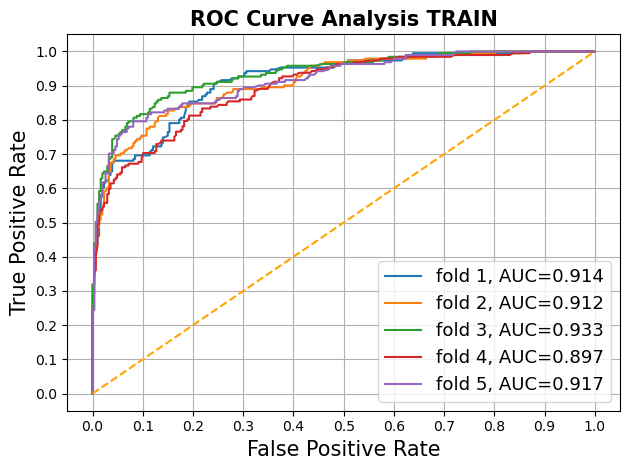

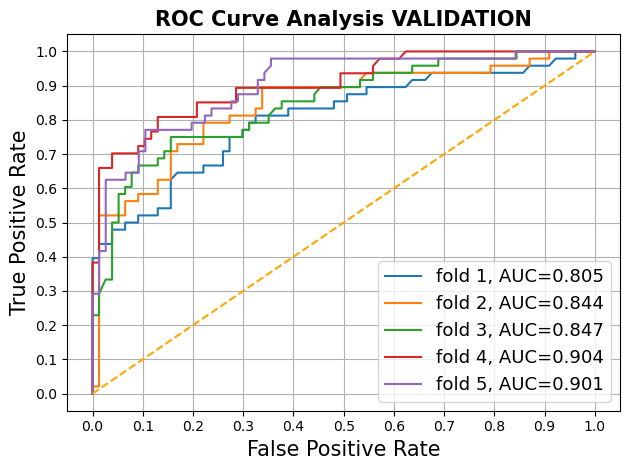

In [59]:
lgb_model.get_rocauc_plots()

In [60]:
lgb_model.get_curve_plots()